In [17]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import pathlib
import pickle
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Bio import SeqIO, Align
from matplotlib import colormaps
from scipy.stats import pearsonr
from datetime import datetime
from sklearn.decomposition import PCA
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
817758


In [19]:
# PORT-EK parameters
k = 11  # This is the length of k-mers
c = 0.8  # This is the conservation thershold used in k-mer rarity filter
m = 1  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.5  # This is the RMSE threshold used to select enriched k-mers

# Relative path to k-mer indices
PROJECT_DIR = "/home/labadmin/repos/PORT-EK 2/projects/test"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["MD","N","O"]
MODE = "one_vs_rest"
GROUP_OF_INTEREST = "MD"
CONTROL_GROUPS = SAMPLE_GROUPS.copy()
CONTROL_GROUPS.remove(GROUP_OF_INTEREST)

GENES = {
    "5' LTR": (1, 634),
    "gag": (790, 2292),
    "pol": (2358, 5096),
    "vif": (5041, 5619),
    "vpr": (5559, 5795),
    "tat_1ex": (5831, 6045),
    "tat_2ex": (8379, 8653),
    "rev_1ex": (5970, 6045),
    "rev_2ex": (8379, 8653),
    "env": (6225, 8795),
    "nef": (8797, 9168),
    "3' LTR": (9086, 9719),
}

REF_SEQ = SeqIO.read(f"{PROJECT_DIR}/input/HXB2.fasta", format="fasta").seq


In [3]:
FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]
AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]
ALIGNER = Align.PairwiseAligner(
    scoring="megablast",
    mode="local"
)

In [4]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than growing the matrix one-by-one.
kmer_set = set()
sample_list = []
kmer_set_in_path = pathlib.Path(f"{PROJECT_DIR}/input/").glob(f"*{k}mer_set.pkl")
sample_list_in_path = pathlib.Path(f"{PROJECT_DIR}/input/").glob("*sample_list.pkl")

for filename in kmer_set_in_path:
    with open(filename, mode="rb") as in_file:
        partial_set = pickle.load(in_file)
    kmer_set.update(partial_set)

for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
    sample_list.extend(partial_list)
sample_list.sort()

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)

group_sample_idx = {f"{group}":[sample for sample in sample_list if sample.split("_")[0] == f"{group}"] for group in SAMPLE_GROUPS}

print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")


Imported 276056 kmers and 293 samples.


In [5]:
# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(f"{PROJECT_DIR}/input/{k}mer_indices").glob("*_count.pkl")

for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    count_dict = {f"{sample_name}": temp_dict.values()}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"{counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Decode k-mer sequences
all_kmer_matrix.index = all_kmer_matrix.index.map(lambda id: portek.decode_kmer(id,k))

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
bin_kmer_matrix = all_kmer_matrix > 0
for group in SAMPLE_GROUPS:
    all_kmer_matrix[f"{group}_freq"] = bin_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
    all_kmer_matrix[f"{group}_avg"] = all_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
del bin_kmer_matrix

# Remove polyA, as its presence and count is mostly dependant on sequencing quality not viral variant.
if k*"A" in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop(k*"A")

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)

293 of 293 indices done.
5697 common k-mers remaining after filtering at a threshold of 0.8.


All_vs_All vs One_vs_Rest

In [15]:
if MODE == "all_vs_all":
    common_kmer_matrix["seq"] = common_kmer_matrix.index
    ERR_COLS = []
    P_COLS = []
    for j in range(1, len(SAMPLE_GROUPS)):
        for i in range(j):
            err_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_err"
            p_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_p-value"
            ERR_COLS.append(err_name)
            P_COLS.append(p_name)
            common_kmer_matrix[err_name] = (
                common_kmer_matrix[f"{SAMPLE_GROUPS[i]}_avg"]
                - common_kmer_matrix[f"{SAMPLE_GROUPS[j]}_avg"]
            )
            common_kmer_matrix[p_name] = common_kmer_matrix["seq"].apply(
                portek.calc_kmer_pvalue,
                args=(
                    group_sample_idx[SAMPLE_GROUPS[i]],
                    group_sample_idx[SAMPLE_GROUPS[j]],
                    common_kmer_matrix,
                ),
            )
            common_kmer_matrix[f"-log10_{p_name}"] = -np.log10(common_kmer_matrix[p_name])
    common_kmer_matrix["RMSE"] = np.sqrt(((common_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1))
    common_kmer_matrix = common_kmer_matrix.sort_values("RMSE", ascending=False)
    common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)
    common_kmer_matrix["group"] = common_kmer_matrix.apply(
        portek.assign_kmer_group_ava, p_cols = P_COLS, avg_cols = AVG_COLS,axis=1
    )
    common_kmer_matrix["exclusivity"] = common_kmer_matrix.apply(
        portek.check_exclusivity, avg_cols = AVG_COLS, axis=1
    )
    common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)

else:
    common_kmer_matrix["seq"] = common_kmer_matrix.index
    ERR_COLS = []
    P_COLS = []
    for j in range(len(CONTROL_GROUPS)):
        err_name = f"{GROUP_OF_INTEREST}-{CONTROL_GROUPS[j]}_err"
        p_name = f"{GROUP_OF_INTEREST}-{CONTROL_GROUPS[j]}_p-value"
        ERR_COLS.append(err_name)
        P_COLS.append(p_name)
        common_kmer_matrix[err_name] = (
            common_kmer_matrix[f"{GROUP_OF_INTEREST}_avg"]
            - common_kmer_matrix[f"{CONTROL_GROUPS[j]}_avg"]
        )
        common_kmer_matrix[p_name] = common_kmer_matrix["seq"].apply(
            portek.calc_kmer_pvalue,
            args=(
                group_sample_idx[GROUP_OF_INTEREST],
                group_sample_idx[CONTROL_GROUPS[j]],
                common_kmer_matrix,
            ),
        )
        common_kmer_matrix[f"-log10_{p_name}"] = -np.log10(common_kmer_matrix[p_name])
    common_kmer_matrix["RMSE"] = np.sqrt(((common_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1))
    common_kmer_matrix = common_kmer_matrix.sort_values("RMSE", ascending=False)
    common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)
    common_kmer_matrix["group"] = common_kmer_matrix.apply(
        portek.assign_kmer_group_ovr, goi = GROUP_OF_INTEREST, p_cols = P_COLS, err_cols = ERR_COLS,axis=1
    )
    common_kmer_matrix["exclusivity"] = common_kmer_matrix.apply(
        portek.check_exclusivity, avg_cols = AVG_COLS, axis=1
    )
    common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)

enriched_groups = [name.split("_")[0] for name in common_kmer_stat_matrix["group"].value_counts().index if "enriched" in name]
enriched_groups

['MD', 'control']

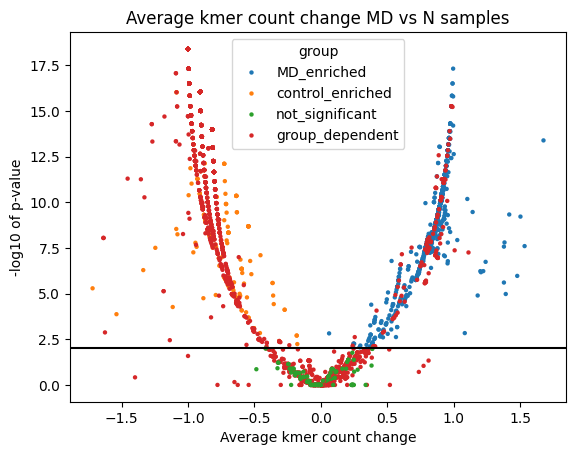

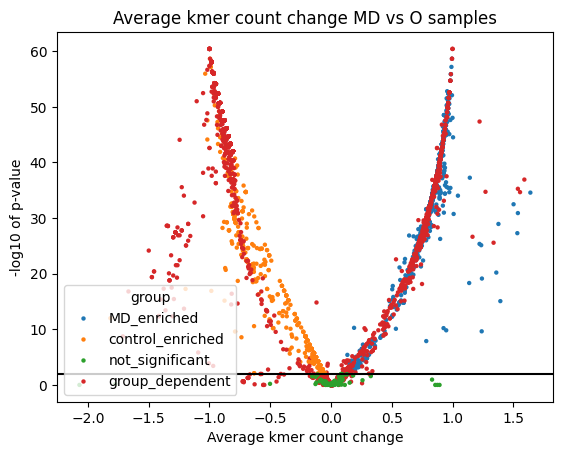

In [11]:
def plot_volcano(matrix: pd.DataFrame, group1:str, group2:str, save:bool = False) -> None:
    fig, ax = plt.subplots()
    plt.axhline(y=-np.log10(0.01), color = 'black')
    ax.autoscale()
    ax.set_title(f'Average kmer count change {group1} vs {group2} samples')
    ax.set_xlabel('Average kmer count change')
    ax.set_ylabel('-log10 of p-value')
    sns.scatterplot(data=matrix, x=f'{group1}-{group2}_err', y = f'-log10_{group1}-{group2}_p-value', s=10, linewidth = 0, hue='group')
    if save == True:
        plt.savefig(f"{PROJECT_DIR}/output/volcano_{group1}_{group2}.svg", dpi = 600, format = "svg")

def plot_all_volcanos(matrix: pd.DataFrame, save:bool = False) -> None:
    for group1 in SAMPLE_GROUPS:
        for group2 in SAMPLE_GROUPS:
            if f"{group1}-{group2}_err" in ERR_COLS:
                plot_volcano(matrix, group1, group2, save)

# plot_volcano(common_kmer_matrix, "MD", "N")
# plot_volcano(common_kmer_matrix, "MD", "O")
plot_all_volcanos(common_kmer_matrix)

In [22]:
common_overrep_kmers = {}
for group in enriched_groups:
    common_overrep_kmers[group] = common_kmer_matrix.loc[common_kmer_matrix["group"] == f"{group}_enriched"].index
rare_overrep_kmers = {}

for group in enriched_groups:
    if group == "control":
        rare_overrep_kmers[group] = all_kmer_matrix.loc[all_kmer_matrix[f"{GROUP_OF_INTEREST}_avg"] == all_kmer_matrix[AVG_COLS].min(axis=1)].index
    else:
        rare_overrep_kmers[group] = all_kmer_matrix.loc[all_kmer_matrix[f"{group}_avg"] == all_kmer_matrix[AVG_COLS].max(axis=1)].index

    rare_overrep_kmers[group] = rare_overrep_kmers[group].difference(common_overrep_kmers[group])
rare_overrep_kmers

{'MD': Index(['AAAAAAAAATC', 'AAAAAAAAATT', 'AAAAAAAACAT', 'AAAAAAAAGAG',
        'AAAAAAAAGGG', 'AAAAAAAATAA', 'AAAAAAAATAG', 'AAAAAAAATCA',
        'AAAAAAAATGA', 'AAAAAAAATGG',
        ...
        'TTTTTTGCTGT', 'TTTTTTGGGAA', 'TTTTTTTACTG', 'TTTTTTTATTG',
        'TTTTTTTGACT', 'TTTTTTTGGGA', 'TTTTTTTTGAC', 'TTTTTTTTTGA',
        'TTTTTTTTTTG', 'TTTTTTTTTTT'],
       dtype='object', length=142132),
 'control': Index(['AAAAAAAAGCC', 'AAAAAAACAAA', 'AAAAAAAGCCT', 'AAAAAAAGGTT',
        'AAAAAAATGTG', 'AAAAAAATTGA', 'AAAAAACAACC', 'AAAAAACAAGC',
        'AAAAAACAATA', 'AAAAAACAATC',
        ...
        'TTTTTGTACCT', 'TTTTTGTAGGT', 'TTTTTGTGGAT', 'TTTTTGTGTGT',
        'TTTTTTAAAGA', 'TTTTTTAACTG', 'TTTTTTAGGCA', 'TTTTTTAGGCC',
        'TTTTTTGGCTG', 'TTTTTTGTGTG'],
       dtype='object', length=112905)}

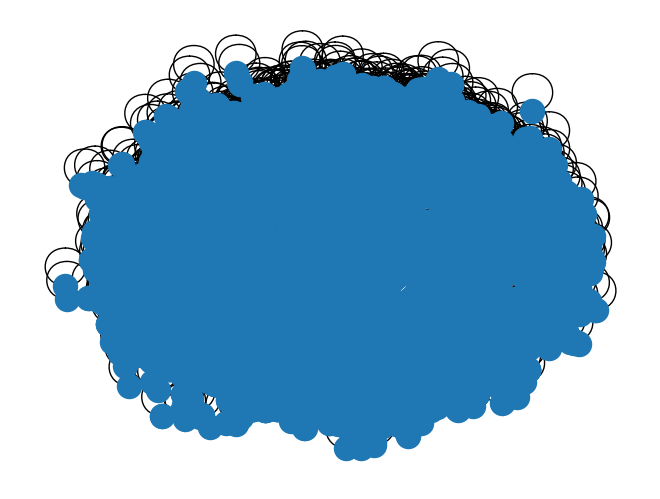

In [23]:
similarity_graphs = {}
for group in enriched_groups:
    similarity_graphs[group] = portek.build_similarity_graph_two_list(
        common_overrep_kmers[group].tolist(), rare_overrep_kmers[group].tolist(), m
    )
for graph in similarity_graphs.values():
    nx.draw(graph)

In [28]:
similarity_graphs["MD"].edges

EdgeView([('GAAACCTTGTT', 'GATACCTTGTT'), ('GAAACCTTGTT', 'GAAACCCTGTT'), ('GAAACCTTGTT', 'GAGACCTTGTT'), ('GAAACCTTGTT', 'GAAACCTTGTT'), ('GAAACCTTGTT', 'GAAACCTTATT'), ('GAAACCTTGTT', 'GAAACCTTTTT'), ('GAAACCTTGTT', 'GAAACTTTGTT'), ('GAAACCTTGTT', 'GAAACCTTCTT'), ('GAAACCTTGTT', 'GACACCTTGTT'), ('ACACCAGACAA', 'ACCCCAGACAA'), ('ACACCAGACAA', 'ACACCAGACAA'), ('ACACCAGACAA', 'ACGCCAGACAA'), ('ACACCAGACAA', 'ACACCAGACCA'), ('ACACCAGACAA', 'ACACCAGAAAA'), ('ACACCAGACAA', 'ACACCACACAA'), ('ACACCAGACAA', 'ACATCAGACAA'), ('ACACCAGACAA', 'ACTCCAGACAA'), ('ACACCAGACAA', 'ACACAAGACAA'), ('ACACCAGACAA', 'ACACCAGGCAA'), ('ACACCAGACAA', 'ACACGAGACAA'), ('ACACCAGACAA', 'ACACCAGATAA'), ('ACCAAGGAAGC', 'ACCAAAGAAGC'), ('ACCAAGGAAGC', 'ACCAAGGAAGC'), ('ACCAAGGAAGC', 'ACCAAGGATGC'), ('ACCAAGGAAGC', 'ACCAAGGGAGC'), ('ACCAAGGAAGC', 'ACAAAGGAAGC'), ('ACCAAGGAAGC', 'ACTAAGGAAGC'), ('ACCAAGGAAGC', 'ACCAAGGAGGC'), ('ATTCAAAATTT', 'ATTCAAAATTT'), ('ATTCAAAATTT', 'ATTCGAAATTT'), ('ATTCAAAATTT', 'ATGCAAAATTT')